In [255]:
# import packages needed
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import os
import pandas as pd
import matplotlib.image as mpimg
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping
from PIL import Image
from zipfile import ZipFile
import os,glob
import cv2
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D, BatchNormalization, Flatten
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications import MobileNet

# Import datasets

In [256]:
# Set constants
BATCH_SIZE = 32
IMAGE_SIZE = 200
EPOCHS = 50
NUM_CLASSES = 3  # Adjust based on your dataset
CHANNELS = 3

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
])

# Import datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "validation",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "test",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)



Found 1034 files belonging to 3 classes.
Found 133 files belonging to 3 classes.
Found 128 files belonging to 3 classes.


# Print data classes


In [257]:
class_names = train_ds.class_names
class_names

['angular_leaf_spot', 'bean_rust', 'healthy']

### Print batch size and labels

In [258]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 200, 200, 3)
[2 2 1 2 2 1 2 2 1 1 1 0 2 0 0 0 2 0 1 1 1 2 0 0 0 0 0 2 1 1 0 2]


### Print sample Images with labels

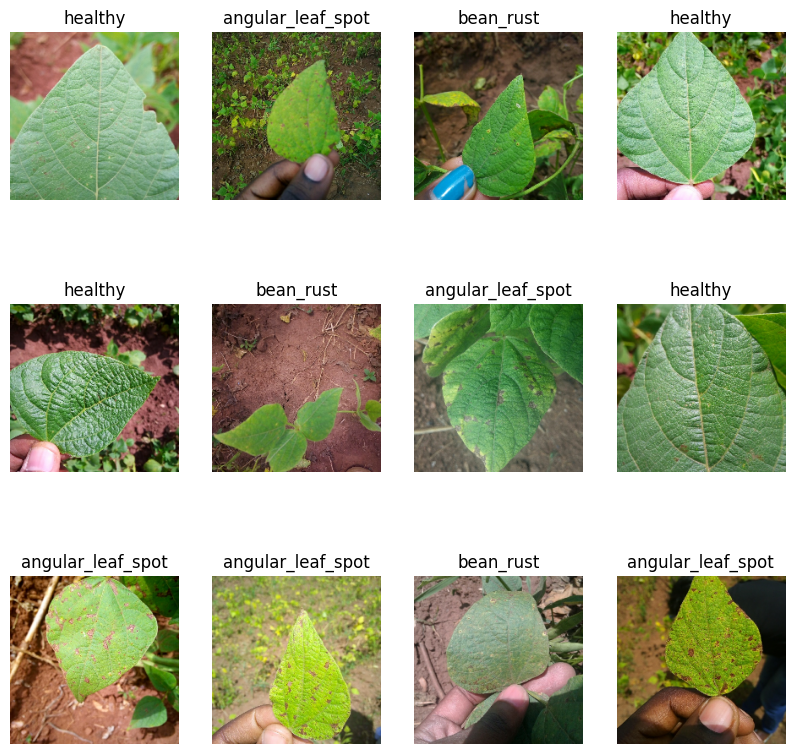

In [259]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [260]:

resize_and_rescale = keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])

# Image augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [261]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [262]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)


(32, 200, 200, 3)
[2 0 1 2 2 0 1 1 0 1 2 0 1 0 0 0 2 0 0 2 2 2 0 2 0 0 1 1 0 2 0 2]


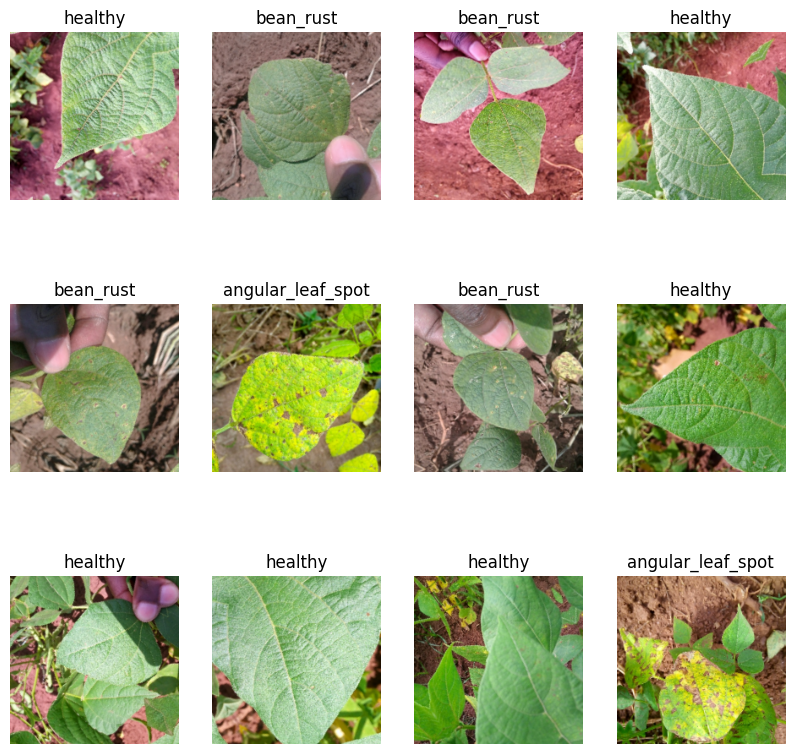

In [263]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

# Build the model 

#### Import Base Model

In [264]:
mobilenet = MobileNet(include_top=False, weights="imagenet", input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Display the full MobileNet architecture
print("Full MobileNet Architecture:")
mobilenet.summary()


C:\Users\Majeed Win10\AppData\Local\Temp\ipykernel_14176\992048449.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = MobileNet(include_top=False, weights="imagenet", input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))


Full MobileNet Architecture:


Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_99 (InputLayer)     │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 100, 100, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 100, 100, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 100, 100, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 100, 100, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 100, 100, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 101, 101, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 50, 50, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 50, 50, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 50, 50, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 50, 50, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 50, 50, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 50, 50, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 50, 50, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 3,206,976 (12.23 MB)

 Non-trainable params: 21,888 (85.50 KB)

#### Build and Compile model

In [265]:
model = keras.Sequential([

    # preprocessing layers
    keras.layers.RandomFlip("horizontal", input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    keras.layers.RandomRotation(0.2),
    keras.layers.RandomZoom(0.2),
    keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    keras.layers.Rescaling(1./255, input_shape=(256, 256, 3)),

    # MobileNet without top classifier
    mobilenet,

    # flatten layer
    keras.layers.Flatten(),

    # dropout layer
    keras.layers.Dropout(0.2),

    # output layer
    keras.layers.Dense(NUM_CLASSES, activation="softmax")
])

# Compile model
model.compile(
    optimizer="SGD",
    loss='sparse_categorical_crossentropy',
    metrics=["accuracy"]
)


#### Fit the model

In [266]:
# Define early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Monitors validation accuracy
    patience=5,              # Number of epochs to wait for improvement
    restore_best_weights=True  # Restores model weights from the epoch with the best validation accuracy
)

#Fit the mode
history= model.fit(train_ds,batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
    callbacks=early_stopping)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.5374 - loss: 20.5832 - val_accuracy: 0.3308 - val_loss: 269.8073
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8158 - loss: 5.3397 - val_accuracy: 0.3684 - val_loss: 56.4207
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.8654 - loss: 1.1055 - val_accuracy: 0.4135 - val_loss: 61.3202
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9141 - loss: 0.6250 - val_accuracy: 0.6241 - val_loss: 14.5032
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9043 - loss: 0.6023 - val_accuracy: 0.7744 - val_loss: 4.0880
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9106 - loss: 0.5388 - val_accuracy: 0.9173 - val_loss: 1.0920
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9522 - loss: 0.2384 - val_accuracy: 0.9549 - val_loss: 0.3017
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9494 - loss: 0.2574 - val_accuracy: 0.9474 - val

### Create a Chart to compare training and validation accuracy and loss

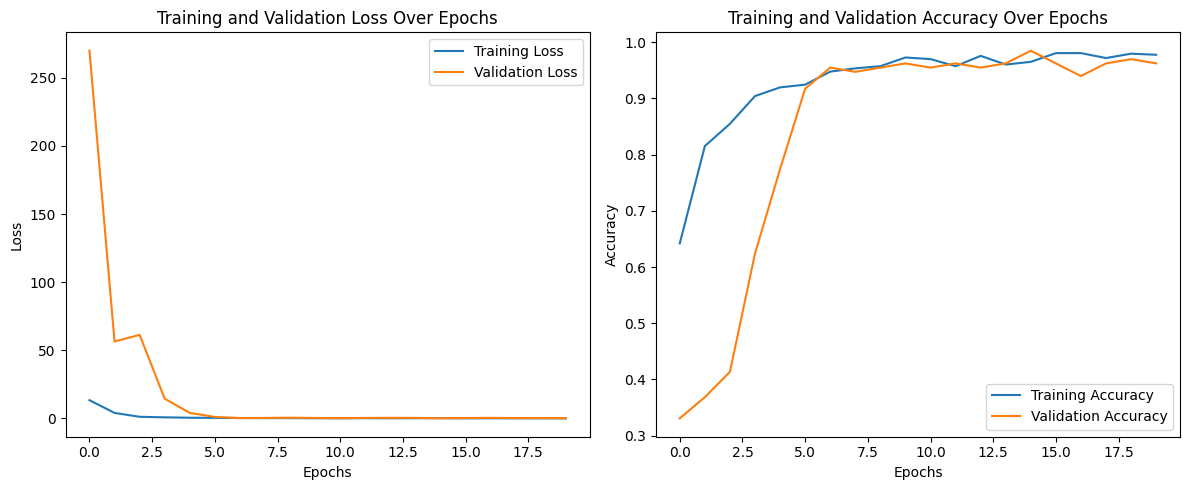

In [267]:

# Create a figure with 2 subplots (one for loss and one for accuracy)
plt.figure(figsize=(12, 5))

# Plotting training and validation loss
plt.subplot(1, 2, 1)  # First subplot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)  # Second subplot
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the graph
plt.show()

## Model Testing

In [268]:
# Generate scores for test sets
scores = model.evaluate(test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step - accuracy: 0.9448 - loss: 0.4486


In [269]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


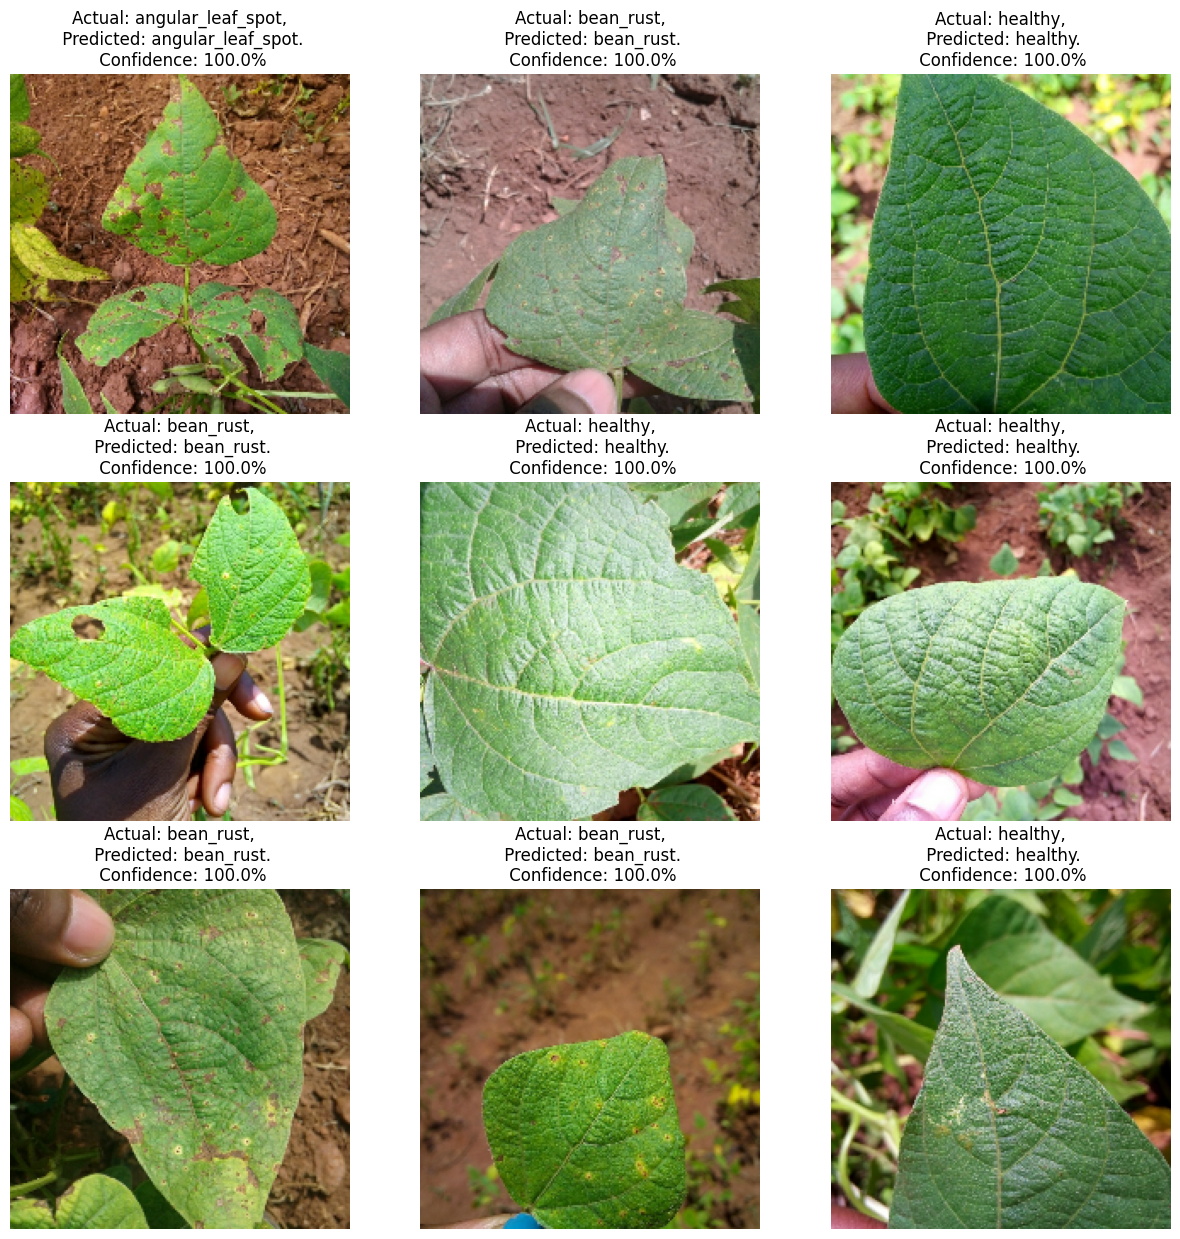

In [270]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - accuracy: 0.9469 - loss: 0.4336
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


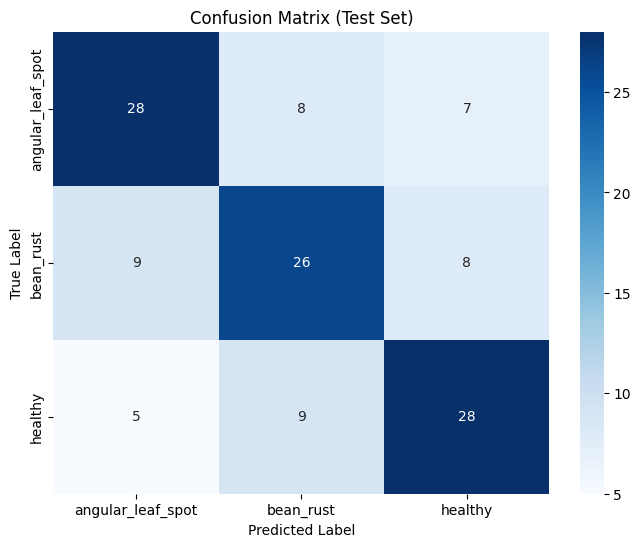

              precision    recall  f1-score   support

           0       0.67      0.65      0.66        43
           1       0.60      0.60      0.60        43
           2       0.65      0.67      0.66        42

    accuracy                           0.64       128
   macro avg       0.64      0.64      0.64       128
weighted avg       0.64      0.64      0.64       128



In [271]:
scores = model.evaluate(test_ds)
# Generate predictions on the test set
y_test_pred = model.predict(test_ds)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)  # Convert probabilities to class labels

# Extract true labels from the test set
y_test_true = np.concatenate([y for x, y in test_ds], axis=0)

# Generate confusion matrix
conf_matrix_test = confusion_matrix(y_test_true, y_test_pred_classes)

# Display the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Test Set)')
plt.show()

# Print classification report for detailed metrics
print(classification_report(y_test_true, y_test_pred_classes))